# Libraries installation

In [1]:
# !pip uninstall torch torchvision torchaudio -y
# !pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu117
# !pip install mne -q
# !pip install wandb -q
# !pip install tensorboard -q

# Constants and libraries

In [2]:
'''
In this section one defines environment variables. 
Because I used this notebook on number of machines, I implemented class especially for this. 
You may not needed in one and use just simple definitions.
'''

from system_variables import SystemVariables

# choose system according your current machine
# SYSTEM_NAME = "Windows"
# SYSTEM_NAME = "Colab"
# SYSTEM_NAME = "Kaggle"
SYSTEM_NAME = "Linux"

sv = SystemVariables(SYSTEM_NAME)
PROJECT_FOLDER = sv.get_project_folder()
SRC_FOLDER = sv.get_src_folder()
OUTPUT_FOLDER = sv.get_output_folder()
TUAB_DIRECTORY, TUAB_TRAIN, TUAB_EVAL = sv.get_TUAB_folders()
DEPR_ANON_DIRECTORY = sv.get_depr_anon_folder()
INHOUSE_DIRECTORY = sv.get_inhouse_folder()

print(SYSTEM_NAME)
print()

print(f"{PROJECT_FOLDER = }")
print(f"{SRC_FOLDER = }")
print(f"{OUTPUT_FOLDER = }")
print()

print(f"{TUAB_DIRECTORY = }")
print(f"{TUAB_TRAIN = }")
print(f"{TUAB_EVAL = }")
print()

print(f"{DEPR_ANON_DIRECTORY = }")
print()

print(f"{INHOUSE_DIRECTORY = }")
print()

Linux

PROJECT_FOLDER = ''
SRC_FOLDER = ''
OUTPUT_FOLDER = ''

TUAB_DIRECTORY = 'Data/TUAB/'
TUAB_TRAIN = 'Data/TUAB/train/normal/01_tcp_ar/'
TUAB_EVAL = 'Data/TUAB/eval/normal/01_tcp_ar/'

DEPR_ANON_DIRECTORY = 'Data/depression_anonymized/'

INHOUSE_DIRECTORY = 'Data/inhouse_dataset/EEG_baseline_with_markers_cleaned/preprocessed_data/EEG_baseline/'



In [3]:
import warnings
warnings.simplefilter("ignore")

import os
import sys
import pickle
import json
import random
from IPython.display import display, clear_output

import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
import matplotlib.pyplot as plt
from matplotlib import rc
rc('animation', html='jshtml')

import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import accuracy_score, f1_score, average_precision_score, roc_auc_score

from tqdm.auto import tqdm as tqdm_auto

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
%load_ext tensorboard

import wandb
!wandb login 1b8e8dc9dcf1a34397a04197c4826d3fe7441dae

import mne

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
cuda


In [4]:
sys.path.append(SRC_FOLDER)

%load_ext autoreload
%autoreload 1
%aimport utils

from utils import SEED
from utils.common import objectName, seed_all
from utils.models_evaluation import evaluateClassifier, evaluateRegressor, evaluateClassifier_inner_outer_cv
from utils.data_reading import DataReader
from utils.plotting import dataset_hists, plotData, dict_to_df, printDatasetMeta, printDataloaderMeta, plotSamplesFromDataset
from utils.dataset import InMemoryDataset
from utils.logger import Logger
from utils.parser import parse_ml_config

from models import get_model, load_weights_from_wandb
from models.modules import encoder_conv, decoder_conv, encoder_conv4, decoder_conv4
from models.VAE import VAE, BetaVAE_H, BetaVAE_B
from models.AE import AE, AE_framework
from models.UNet import UNet

from training import train_eval

# Config

In [9]:
train_config = {
    "loss_coefs": {
        "ampl": 1,
        "vel": 0,
        "acc": 0,
        "frq": 0,
        "kl": 1
    },
    "masking" :{
        "n_masks" : 0, #0/1
        "mask_ratio" : 0 #[0, 1]
    },
    
    "start_epoch": 0, # including
    "end_epoch": 1, # excluding,
    "step_max" : None,

    "validation": {
        "check_period": 1e10,
        "plot_period": None, #1e10
    }
}

logger_config = {
    "log_type" : "none", #"wandb"/"tensorboard"/"none"
}

model_config = {
    "model": "AE",
    "loss_reduction" : "mean",
    "model_description": "test", #delete
    
    # "artifact" : 'dmitriykornilov_team/EEG_age_prediction/AE:v18',
    # "file": '50_epoch.pth'
}

dataset_config = {
    "dataset_source" : "inhouse", 
    "batch_size": 256,
    "num_workers": 0,
    "minmax": "across_whole_sample", #only for log
    "record_part": "10 s", #only for log
    "task": "MDD classification", #only for log
    "dataset": "depression_anonymized", #inhouse_dataset/depression_anonymized/TUAB
    "dataset_file": DEPR_ANON_DIRECTORY + "dataset_128_10.0.pkl", #DEPR_ANON_DIRECTORY + "dataset_128_10.0.pkl" / INHOUSE_DIRECTORY + "dataset.pkl" / TUAB_DIRECTORY + "dataset_fz_cz_pz_3x124.pkl" 
}

optimizer_config = {
    "optimizer" : "AdamW",
    "kwargs": {
        "lr": 1e-3
    }
}

scheduler_config = {
    "scheduler" : "ReduceLROnPlateau",
    "kwargs": {
        "factor": 0.5,
        "patience": 3, 
        "verbose": True
    }
}

ml_config = {
    "avg_embeddings_over_time": True,
    "plot_type": "classification", #"regression"/"classification"
    "ml_model": {
        "scaler" : "preprocessing.StandardScaler",
        "clf": "svm.SVC",
    },
    "ml_param_grid" : {
        'clf__kernel': ['linear'],
        'clf__C': list(np.logspace(-1, 1, 3)),
        'clf__probability': [True],
        'clf__class_weight': ['balanced'],
        'clf__random_state': [SEED]
    },
    "ml_eval_function" : [
        "evaluateClassifier_inner_outer_cv",
        "evaluateClassifier", 
    ],
    "ml_eval_function_tag" : ["cv", "d"],
    "ml_eval_function_kwargs" : [
        {
            "verbose" : 1,
            "SEED" : SEED,
            "cv_scorer" : "accuracy_score",
            "metrics" : [("average_precision_score", "soft"), ("roc_auc_score", "soft"), ("accuracy_score", "hard"), ("f1_score", "hard")],
            "n_splits" : 10,
        },
        {
            "verbose" : 1,
            "test_size" : 0.33,
            "SEED" : SEED,
            "cv_scorer" : "accuracy_score",
            "metrics" : [("average_precision_score", "soft"), ("roc_auc_score", "soft"), ("accuracy_score", "hard"), ("f1_score", "hard")],
            # "metrics_for_CI" : [("average_precision_score", "soft"), ("roc_auc_score", "soft"), ("accuracy_score", "hard"), ("f1_score", "hard")],
            "n_bootstraps" : 1000
        },
    ],
    "ml_metric_prefix" : "clf",
    
    # ml_model=Pipeline([('scaler', StandardScaler()), ('reg', Ridge())]),
    # ml_param_grid={
    #     'reg__alpha': np.logspace(-2, 2, 5),
    #     # 'reg__solver': ['sag'],
    #     # 'reg__tol': [1e-4]
    # },
    # ml_eval_function=evaluateRegressor,
    # ml_metric_names=["mse_test", "mse_train"],
    # ml_metric_prefix="reg",
}


default_config = {
    "project_name": 'EEG_age_prediction',
    "method": "direct restoration",
    "save_path" : OUTPUT_FOLDER + 'model_weights/',
    
    "dataset": dataset_config,
    "model": model_config,
    "optimizer" : optimizer_config,
    "scheduler": scheduler_config,
    "train": train_config,
    "ml": ml_config,
    "logger": logger_config,
}

# print("Config:", json.dumps(default_config, indent=4))

# Experiments

In [10]:
experiments = [
    default_config,
]

# Training

In [11]:
def train(config, verbose=1):
    try:
        #Data reading
        print("Data reading")
        train_set, val_set, test_set = DataReader(config["dataset"]["dataset_file"], dataset_type=config["dataset"]["dataset"]).split()    
        chunks_train, chunks_val, chunks_test = train_set["chunk"], val_set["chunk"], test_set["chunk"]
        targets_train, targets_val, targets_test = train_set["target"], val_set["target"], test_set["target"]
        
        config["dataset"].update({
            "samples_shape": chunks_train[0].shape,
            "n_train_samples": len(chunks_train),
            "n_validation_samples": len(chunks_val),
            "n_test_samples": len(chunks_test),
        })
    
        t_max=None
        train_dataset = InMemoryDataset(chunks_train, is_squeeze=False, is_unsqueeze=False, t_max=t_max)
        val_dataset = InMemoryDataset(chunks_val, is_squeeze=False, is_unsqueeze=False, t_max=t_max)
        test_dataset = InMemoryDataset(chunks_test, is_squeeze=False, is_unsqueeze=False, t_max=t_max)
    
        if verbose > 0: 
            printDatasetMeta(train_dataset, val_dataset, test_dataset)
            plotSamplesFromDataset(train_dataset)
    
        #Dataloader
        train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=config["dataset"]['batch_size'], num_workers=config["dataset"]['num_workers'])
        val_dataloader = DataLoader(val_dataset, shuffle=False, batch_size=config["dataset"]['batch_size'], num_workers=config["dataset"]['num_workers'])
        test_dataloader = DataLoader(test_dataset, shuffle=False, batch_size=config["dataset"]['batch_size'], num_workers=config["dataset"]['num_workers'])
    
        if verbose > 0: printDataloaderMeta(train_dataloader, val_dataloader, test_dataloader)
    
        #Model
        config["model"].update({
            "input_dim" : train_dataset[0].shape,
        })
        model, config["model"] = get_model(config["model"])
        model = model.to(device)
        if verbose > 0: print('model ' + config["model"]['model_description'] + ' is created')
    
        #Download weights
        if "artifact" in config["model"] and "file" in config["model"]:
            model = load_weights_from_wandb(model, config["model"]["artifact"], config["model"]["file"], verbose=verbose)
    
        # Let's check that forward works
        model.eval()
        test_data_point = train_dataset[0][None].to(device)
        print("Test data point shape:", test_data_point.shape)
        print("Test inference:", len(model(test_data_point)))
        print("Test reconstruct:", model.reconstruct(test_data_point).shape)
        print("Test encode:", model.encode(test_data_point).shape)
    
        #optimizer and scheduler
        optimizer = getattr(torch.optim, config["optimizer"]["optimizer"])(model.parameters(), **config["optimizer"]["kwargs"])
        if verbose > 0: print(f'Optimizer {type(optimizer).__name__} is instantiated')
    
        scheduler = getattr(torch.optim.lr_scheduler, config["scheduler"]["scheduler"])(optimizer, **config["scheduler"]["kwargs"])
        if verbose > 0: print(f'Scheduler {type(scheduler).__name__} is instantiated')
    
        logger = Logger(
            log_type=config["logger"]["log_type"], 
            run_name=config["model"]["model_description"],
            save_path=config["save_path"],
            model=model,
            model_name=config["model"]["model"],        
            project_name=config["project_name"],
            config=config,
            model_description=config["model"]["model_description"],
        #         log_dir = OUTPUT_FOLDER + "logs/"
        )
    
        #parse ml config
        #should be just before training because replace names by objects
        config["ml"] = parse_ml_config(config["ml"])
    
        #seed
        seed_all(SEED)
    
        #training
        # best_loss = np.inf
        best_clf_accuracy = -np.inf
        best_model = None
        best_epoch = None
        final_model = None
        
        for epoch in tqdm_auto(range(config["train"]['start_epoch'], config["train"]['end_epoch'])):
            #######
            # train
            #######
            print("##### Training... #####")
            model, results = train_eval(
                train_dataloader,
                model,
                device=device,
                mode="train",
                optimizer=optimizer,
                epoch=epoch,
                logger=logger,
                loss_coefs=config["train"]["loss_coefs"],
                loss_reduction=config["model"]["loss_reduction"],
                is_mask=(config["train"]["masking"]["n_masks"] != 0 and config["train"]["masking"]["mask_ratio"] != 0),
                mask_ratio=config["train"]["masking"]["mask_ratio"],
                step_max=config["train"]["step_max"], 
            )
            if results == {}: break
            display(dict_to_df(results))
    
            ############
            # validation
            ############
            print("##### Validation... #####")
            model, results = train_eval(
                val_dataloader,
                model,
                device=device,
                mode="validation",
                test_dataset=val_dataset,
                targets_test=targets_val,
                check_period=config["train"]["validation"]["check_period"],
                plot_period=config["train"]["validation"]["plot_period"],
                epoch=epoch,
                logger=logger,
                loss_coefs=config["train"]["loss_coefs"],
                loss_reduction=config["model"]["loss_reduction"],
                is_mask=(config["train"]["masking"]["n_masks"] != 0 and config["train"]["masking"]["mask_ratio"] != 0),
                mask_ratio=config["train"]["masking"]["mask_ratio"],
                step_max=config["train"]["step_max"], 
                **config["ml"],
            )
            if results == {}: break
            display(dict_to_df(results))
    
            scheduler.step(results['loss'])
            logger.save_model(epoch)
            final_model = model
    
            zero_ml_tag = config["ml"]["ml_eval_function_tag"][0]
            if results[f'clf.{zero_ml_tag}.test.accuracy.cv'] >= best_clf_accuracy:
                best_clf_accuracy = results[f'clf.{zero_ml_tag}.test.accuracy.cv']
                best_model = model
                best_epoch = best_epoch
                print(f"New best classifier accuracy = {best_clf_accuracy} on epoch {epoch}")
            
            # if results['loss'] < best_loss:
            #     best_loss = results['loss']
            #     best_model = model
            #     best_epoch = best_epoch
            #     print(f"New best loss = {best_loss} on epoch {epoch}")
    
        logger.save_model(config["train"]['end_epoch'])
    
        ######
        # test
        ######
        for model, mode in zip([final_model, best_model], ["final", "test"]):
            print(f"##### Testing in {mode} mode... #####")
            _, results = train_eval(
                test_dataloader,
                model,
                device=device,
                mode=mode,
                test_dataset=test_dataset,
                targets_test=targets_test,
                check_period=1e10,
                plot_period=1e10,
                epoch=config["train"]['end_epoch'],
                logger=logger,
                loss_coefs=config["train"]["loss_coefs"],
                loss_reduction=config["model"]["loss_reduction"],
                is_mask=(config["train"]["masking"]["n_masks"] != 0 and config["train"]["masking"]["mask_ratio"] != 0),
                mask_ratio=config["train"]["masking"]["mask_ratio"],
                step_max=config["train"]["step_max"], 
                **config["ml"],
            )
            display(dict_to_df(results))
        
        logger.update_summary("validation.best_epoch", best_epoch)
        logger.finish()
        
    except:
        print("Experiment failed")

Data reading

Chunks shape: (3, 1280) , length: 1068 , keys: dict_keys(['chunk', 'target', 'patient'])
N patients = 178
Train=142, validation=18, test=18


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1068/1068 [00:00<00:00, 31147.12it/s]

Train: 852 (3, 1280)
Validation: 108 (3, 1280)
Test: 108 (3, 1280)
Train dataset: 852
Val dataset: 108
Test dataset: 108
Train sample shape: torch.Size([3, 1280])
Val sample shape: torch.Size([3, 1280])
Test sample shape: torch.Size([3, 1280])
Train sample type: torch.FloatTensor
Val sample type: torch.FloatTensor
Test sample type: torch.FloatTensor


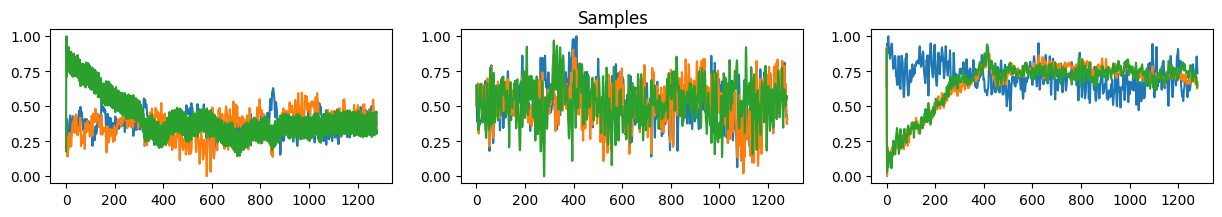

Train dataloader: 4
Val dataloader: 1
Test dataloader: 1
model test is created
Test data point shape: torch.Size([1, 3, 1280])
Test inference: 1
Test reconstruct: torch.Size([1, 3, 1280])
Test encode: torch.Size([1, 32, 160])
Optimizer AdamW is instantiated
Scheduler ReduceLROnPlateau is instantiated
No logging


  0%|                                                                                                                                    | 0/1 [00:00<?, ?it/s]

##### Training... #####
Model is in train mode


,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,lr
0,0.740,0.260,0.151,-0.854,0.740,0.004,0.003,0.001,0.860,0.001


##### Validation... #####
Model is in evaluation mode
Classifier/regressor metrics evaluation...
GridSearchCV
Evaluation on the train data
Evaluation on the test data
Data split
GridSearchCV
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Evaluation on the train data
Evaluation on the test data


,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,clf.cv.train.average_precision.cv,clf.cv.train.average_precision.se.cv,clf.cv.train.roc_auc.cv,clf.cv.train.roc_auc.se.cv,clf.cv.train.accuracy.cv,clf.cv.train.accuracy.se.cv,clf.cv.train.f1.cv,clf.cv.train.f1.se.cv,clf.cv.test.average_precision.cv,clf.cv.test.average_precision.se.cv,clf.cv.test.roc_auc.cv,clf.cv.test.roc_auc.se.cv,clf.cv.test.accuracy.cv,clf.cv.test.accuracy.se.cv,clf.cv.test.f1.cv,clf.cv.test.f1.se.cv,clf.d.train.average_precision,clf.d.train.roc_auc,clf.d.train.accuracy,clf.d.train.f1,clf.d.train.sensitivity,clf.d.train.specificity,clf.d.test.average_precision,clf.d.test.roc_auc,clf.d.test.accuracy,clf.d.test.f1,clf.d.test.sensitivity,clf.d.test.specificity
0,0.707,0.293,0.000,-0.360,0.707,0.003,0.003,0.001,0.841,0.498,0.179,0.385,0.333,0.529,0.328,0.538,0.321,0.549,0.227,0.467,0.291,0.489,0.230,0.494,0.280,0.423,0.162,0.472,0.642,0.810,0.000,0.658,0.635,0.389,0.500,0.917,0.125


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:40<00:00, 40.56s/it]

New best classifier accuracy = 0.4890909090909091 on epoch 0
##### Testing in final mode... #####
Model is in evaluation mode
Epoch 1, step 0
Plotting PCA...


,Explained variance,Ratio
0,5.089505e-12,0.997898
1,2.881176e-15,0.000565


Plotting reconstruction...


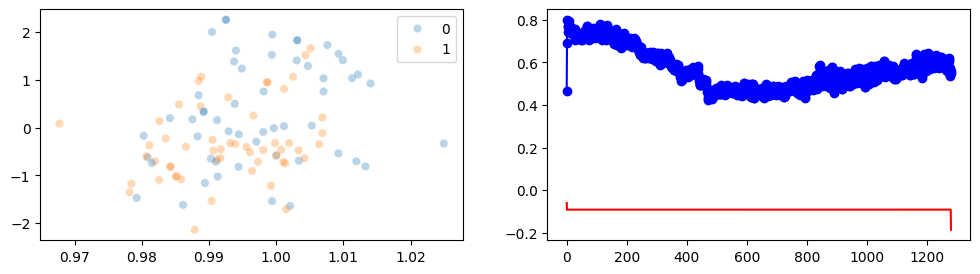

Classifier/regressor metrics evaluation...
GridSearchCV
Evaluation on the train data
Evaluation on the test data
Data split
GridSearchCV
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Evaluation on the train data
Evaluation on the test data


,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,clf.cv.train.average_precision.cv,clf.cv.train.average_precision.se.cv,clf.cv.train.roc_auc.cv,clf.cv.train.roc_auc.se.cv,clf.cv.train.accuracy.cv,clf.cv.train.accuracy.se.cv,clf.cv.train.f1.cv,clf.cv.train.f1.se.cv,clf.cv.test.average_precision.cv,clf.cv.test.average_precision.se.cv,clf.cv.test.roc_auc.cv,clf.cv.test.roc_auc.se.cv,clf.cv.test.accuracy.cv,clf.cv.test.accuracy.se.cv,clf.cv.test.f1.cv,clf.cv.test.f1.se.cv,clf.d.train.average_precision,clf.d.train.roc_auc,clf.d.train.accuracy,clf.d.train.f1,clf.d.train.sensitivity,clf.d.train.specificity,clf.d.test.average_precision,clf.d.test.roc_auc,clf.d.test.accuracy,clf.d.test.f1,clf.d.test.sensitivity,clf.d.test.specificity
0,0.709,0.291,-0.000,-0.352,0.709,0.003,0.002,0.001,0.842,0.724,0.221,0.677,0.211,0.613,0.198,0.601,0.221,0.722,0.313,0.658,0.356,0.543,0.286,0.532,0.354,0.910,0.889,0.806,0.788,0.743,0.865,0.710,0.704,0.583,0.595,0.579,0.588


##### Testing in test mode... #####
Model is in evaluation mode
Epoch 1, step 0
Plotting PCA...


,Explained variance,Ratio
0,5.071750e-12,0.997889
1,2.880663e-15,0.000567


Plotting reconstruction...


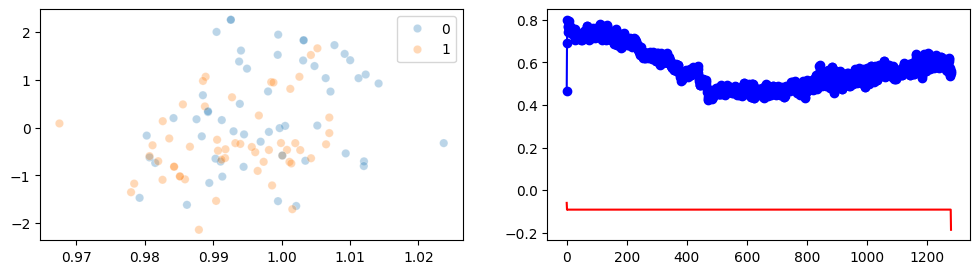

Classifier/regressor metrics evaluation...
GridSearchCV
Evaluation on the train data
Evaluation on the test data
Data split
GridSearchCV
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Evaluation on the train data
Evaluation on the test data


,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,clf.cv.train.average_precision.cv,clf.cv.train.average_precision.se.cv,clf.cv.train.roc_auc.cv,clf.cv.train.roc_auc.se.cv,clf.cv.train.accuracy.cv,clf.cv.train.accuracy.se.cv,clf.cv.train.f1.cv,clf.cv.train.f1.se.cv,clf.cv.test.average_precision.cv,clf.cv.test.average_precision.se.cv,clf.cv.test.roc_auc.cv,clf.cv.test.roc_auc.se.cv,clf.cv.test.accuracy.cv,clf.cv.test.accuracy.se.cv,clf.cv.test.f1.cv,clf.cv.test.f1.se.cv,clf.d.train.average_precision,clf.d.train.roc_auc,clf.d.train.accuracy,clf.d.train.f1,clf.d.train.sensitivity,clf.d.train.specificity,clf.d.test.average_precision,clf.d.test.roc_auc,clf.d.test.accuracy,clf.d.test.f1,clf.d.test.sensitivity,clf.d.test.specificity
0,0.709,0.291,-0.000,-0.352,0.709,0.003,0.002,0.001,0.842,0.719,0.251,0.679,0.308,0.561,0.367,0.524,0.415,0.719,0.247,0.654,0.291,0.646,0.220,0.640,0.268,0.824,0.867,0.819,0.812,0.778,0.861,0.686,0.642,0.583,0.634,0.722,0.444


In [12]:
for config in experiments:
    train(config)